***
# 3. Initial Analysis and EDA
***

## Background

The latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. 

The 'topics' signifies the hidden, to be estimated, variable relations that link words in a
vocabulary and their occurrence in documents. A document is seen as a mixture of topics. Topic
models discover the hidden themes through out the collection and annotate the documents
according to those themes. Each word is seen as drawn from one of those topics. Finally, A
document coverage distribution of topics is generated and it provides a new way to explore the
data on the perspective of topics ([source](https://www.researchgate.net/profile/Solomia-Fedushko/publication/331276764_Proceedings_of_the_Sixth_International_Conference_on_Computer_Science_Engineering_and_Information_Technology_CCSEIT_2016_Vienna_Austria_May_2122_2016/links/5c6fcd63299bf1268d1bc2b0/Proceedings-of-the-Sixth-International-Conference-on-Computer-Science-Engineering-and-Information-Technology-CCSEIT-2016-Vienna-Austria-May-2122-2016.pdf#page=212)). 

## Analysis

### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

# Enables Pandas to display all the columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Enables Pandas to display long strings properly
#pd.options.display.max_colwidth = 100
%matplotlib inline

In [2]:
text_df = pd.read_csv('../dataset/text_corpus.csv')

In [3]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471 entries, 0 to 4470
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text_column  4471 non-null   object
dtypes: object(1)
memory usage: 35.1+ KB


In [4]:
text_df.head(5)

,text_column
0,Nothing is coming out.
1,"Well, I declare."
2,"So today, we are going to be trying out some viral beauty products. You look for new things and ..."
3,What I've tried. It's probably I think in recent years the facial roller and lock washer has bee...
4,I do use it. I feel like it does work and it really say right that if you using just one muscara...


In [5]:
# check for null value in text_df
text_df[text_df['text_column'].isnull()]

,text_column


In [6]:
# total number of words in the raw dataset
text_df['text_column'].str.count('\w+').sum()

315527

From the 45 hours of audio processed through Google Cloud Speech-to-Text API, a word corpus consisting of 315527 words is obtained.

### Wordcloud

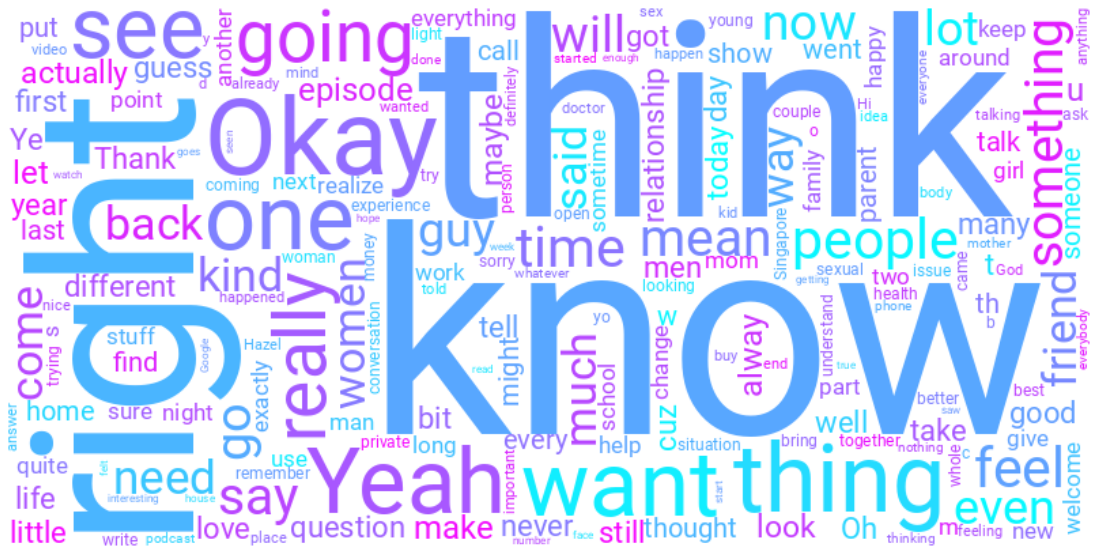

In [7]:
wordcloud_0 = WordCloud(font_path = '../media/Roboto-Regular.ttf', collocations = False, background_color = 'white', colormap='cool', width=800, height=400).generate(str(text_df))

plt.figure(figsize=(20,10))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data Cleaning

### Regex

In [8]:
# define regex function to clean up text
def regex(text):
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub('http\S+', '', text)
    text = re.sub(r'\&\w*;', '', text)
    text = re.sub('xa0', '', str(text)).strip()
    text = re.sub('x200b', '', str(text)).strip()
        
    # Make texts lowercase
    text = text.lower()
    
    # Remove url
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w*', '', text)
    
    # Remove new lines
    text = text.replace('\n',' ').lower()
        
    # Remove punctuation and split 's, 't, 've with a space for filter
    text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
        
    # Remove texts with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove special characters
    text = ''.join(c for c in text if c <= '\uFFFF') 
    
    return text

In [9]:
# apply regex function
text_df['text_column'] = text_df['text_column'].apply(regex)
text_df.head(5)

,text_column
0,nothing coming out
1,well declare
2,today are going trying out some viral beauty products you look for new things and sweat l...
3,what tried probably think recent years the facial roller and lock washer has been properl...
4,use feel like does work and really say right that you using just one muscara okay doin...


### Stopwords

In [10]:
# define stopwords from nltk
all_stopwords = stopwords.words('english')

In [11]:
# define additional stopwords based on n-grams graphs and add to stopword list
additional_stopwords = ['welcome', 'ha', 'like', 'would', 'wa', 'mean', 'say', 'feel', 'see', 'okay', 'thank',
                        'think', 'yeah', 'right', 'something', 'really', 'nicole', 'episode', 'bit', 'little',
                        'spotify', 'apple', 'patreon', 'know', 'going', 'get', 'thing', 'want', 'one', 'even']
all_stopwords.extend(additional_stopwords)

# EDA

### Tokenization and Lemmatization

In [12]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

def tok_stem_drop(row):

    # tokenise
    row['text_column'] = [tok for tok in tokenizer.tokenize(row['text_column'].lower())]
    
    # lemmatise
    row['lemma_text_column'] = [lemmatizer.lemmatize(tok) for tok in row['text_column']]
  
    # drop stopwords
    row['lemma_stop_text_column'] = [tok for tok in row['lemma_text_column'] if tok not in all_stopwords]
    
    return row
    
clean_df = text_df.apply(tok_stem_drop, axis=1)

In [13]:
clean_df.head(10)

,text_column,lemma_text_column,lemma_stop_text_column
0,"[nothing, coming, out]","[nothing, coming, out]","[nothing, coming]"
1,"[well, declare]","[well, declare]","[well, declare]"
2,"[today, are, going, trying, out, some, viral, beauty, products, you, look, for, new, things, and...","[today, are, going, trying, out, some, viral, beauty, product, you, look, for, new, thing, and, ...","[today, trying, viral, beauty, product, look, new, sweat, lot, interesting, native, product, int..."
3,"[what, tried, probably, think, recent, years, the, facial, roller, and, lock, washer, has, been,...","[what, tried, probably, think, recent, year, the, facial, roller, and, lock, washer, ha, been, p...","[tried, probably, recent, year, facial, roller, lock, washer, properly, leather]"
4,"[use, feel, like, does, work, and, really, say, right, that, you, using, just, one, muscara, oka...","[use, feel, like, doe, work, and, really, say, right, that, you, using, just, one, muscara, okay...","[use, doe, work, using, muscara, wrong, according, make, lot, beautiful, also, talk, track, incr..."
5,"[what, this, viral, virus, but, would, you, buy, this, goodness, buffalo, opinion]","[what, this, viral, virus, but, would, you, buy, this, goodness, buffalo, opinion]","[viral, virus, buy, goodness, buffalo, opinion]"
6,"[when, when, gone, too, far, even, buy, them]","[when, when, gone, too, far, even, buy, them]","[gone, far, buy]"
7,"[have, little, stick, here]","[have, little, stick, here]",[stick]
8,"[how, you, remove, the, right, time, without, trying, idealist, think, going, hop, 2022]","[how, you, remove, the, right, time, without, trying, idealist, think, going, hop, 2022]","[remove, time, without, trying, idealist, hop, 2022]"
9,"[places, where, number, shaver]","[place, where, number, shaver]","[place, number, shaver]"


In [14]:
# check
clean_df.shape

(4471, 3)

## Word Vectorization

### N-gram Frequency

The N-gram frequency is used to show the counts of each unique word in the text corpus.

In [15]:
# extract separate series and remove square brackets
clean_text = pd.Series(clean_df['lemma_stop_text_column'].str.join(', '))

In [16]:
clean_text.head(10)

0                                                                                        nothing, coming
1                                                                                          well, declare
2    today, trying, viral, beauty, product, look, new, sweat, lot, interesting, native, product, inte...
3                         tried, probably, recent, year, facial, roller, lock, washer, properly, leather
4    use, doe, work, using, muscara, wrong, according, make, lot, beautiful, also, talk, track, incre...
5                                                          viral, virus, buy, goodness, buffalo, opinion
6                                                                                         gone, far, buy
7                                                                                                  stick
8                                                     remove, time, without, trying, idealist, hop, 2022
9                                                      

In [17]:
# check series
clean_text.shape

(4471,)

# Data Visualizations

In [18]:
# create function for Count Vectorizer Visualization
def cvec_ngram(range_value):

    # Instantiate Vectorizer
    cvec_vectorizer = CountVectorizer(ngram_range=(range_value, range_value), min_df=5, max_features=100)
    
    # Creating dataframe based on vectorizer
    text_visual = cvec_vectorizer.fit_transform(clean_text)
    text_visual_df = pd.DataFrame(text_visual.todense(), columns=cvec_vectorizer.get_feature_names())
    
    # Plotting bar graph
    plt.figure(figsize=(12, 6))

    
    plt.subplot(1, 2, 1) 
    text_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', colormap='Pastel2');
    plt.title('Top 20 Words in text corpus (Count Vectorizer)', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.xlabel('Frequency', fontsize=15)
    plt.tick_params(labelsize=15)

    plt.tight_layout()

In [19]:
# create function for TF-IDF Vectorizer Visualization
def tvec_ngram(range_value):

    # Instantiate Vectorizer
    tvec_vectorizer = TfidfVectorizer(ngram_range=(range_value, range_value), min_df=5, max_features=100)
    
    # Creating dataframe based on vectorizer
    text_visual = tvec_vectorizer.fit_transform(clean_text)
    text_visual_df = pd.DataFrame(text_visual.todense(), columns=tvec_vectorizer.get_feature_names())

    # Plotting bar graph
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    text_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', colormap='Pastel1');
    plt.title('Top 20 Words in text corpus (TFIDF Vectorizer)', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.xlabel('Frequency', fontsize=15)
    plt.tick_params(labelsize=15)    
    
    plt.tight_layout()

### Unigrams (Count Vectorizer)

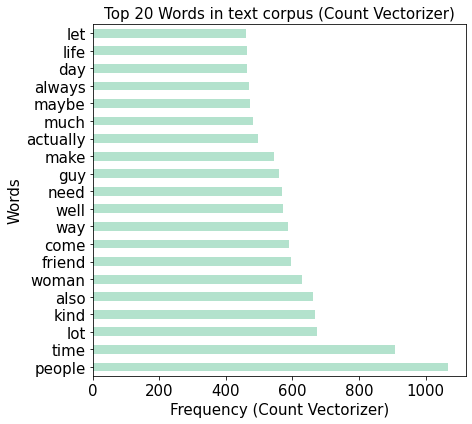

In [20]:
cvec_ngram(1)

### Unigrams (TF-IDF Vectorizer)

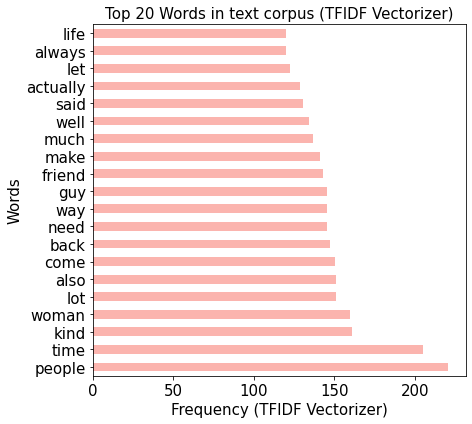

In [21]:
tvec_ngram(1)

### Bigrams (Count Vectorizer)

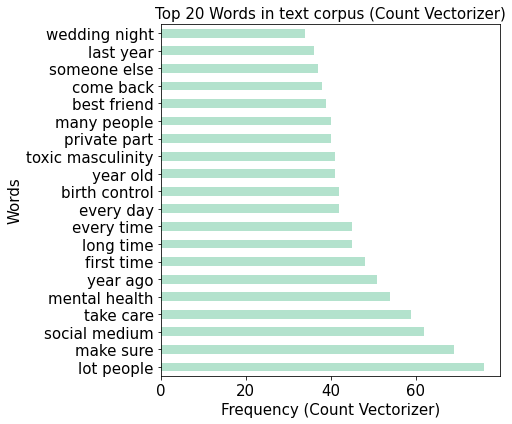

In [22]:
cvec_ngram(2)

### Bigrams (TF-IDF Vectorizer)

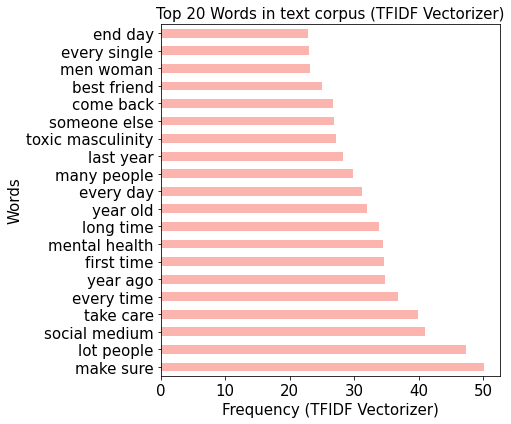

In [23]:
tvec_ngram(2)

### Trigrams (Count Vectorizer)

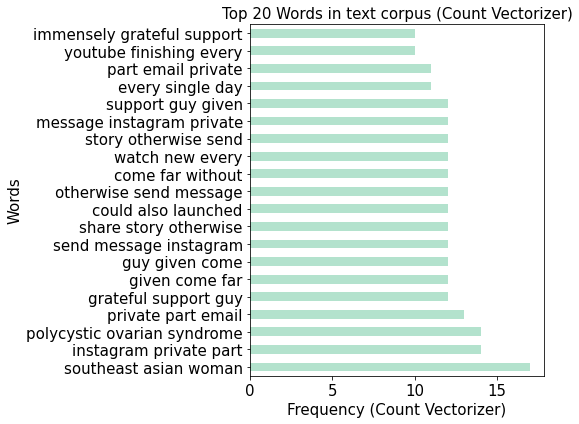

In [24]:
cvec_ngram(3)

### Trigrams (TF-IDF Vectorizer)

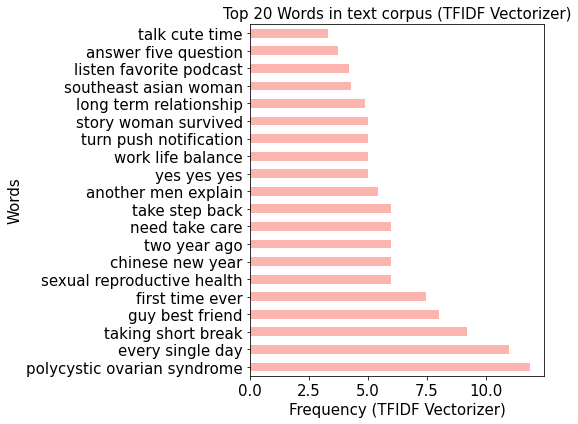

In [25]:
tvec_ngram(3)

### Initial EDA Observations

- The unigrams do not give much insights but the results for bigrams and trigrams are very promising. From the bigrams, we can infer that topics related to <b>health</b> such as mental health, take care, toxic masculinity and birth control are frquently discussed. There might also be discussion revolving around <b>harrassment</b> with the use of the words social media, private parts, and make sure. <b>Relationships</b> are also discussed with the words best friend, man woman and wedding night. Many of the the bigrams are related to the <b>passage of time</b> involving the words day or year but the contexts that they are used in are hard to establish.
- The trigrams fit into the general topics mentioned above, and also adds <b>identity</b> as a topic with the words southeast asian woman, as well as expressions of <b>gratefulness</b> and <b>career</b> with work life balance.

Potential topics: health, harassment, relationships, passage of time, identity, gratefulness and career
              

### Word Cloud

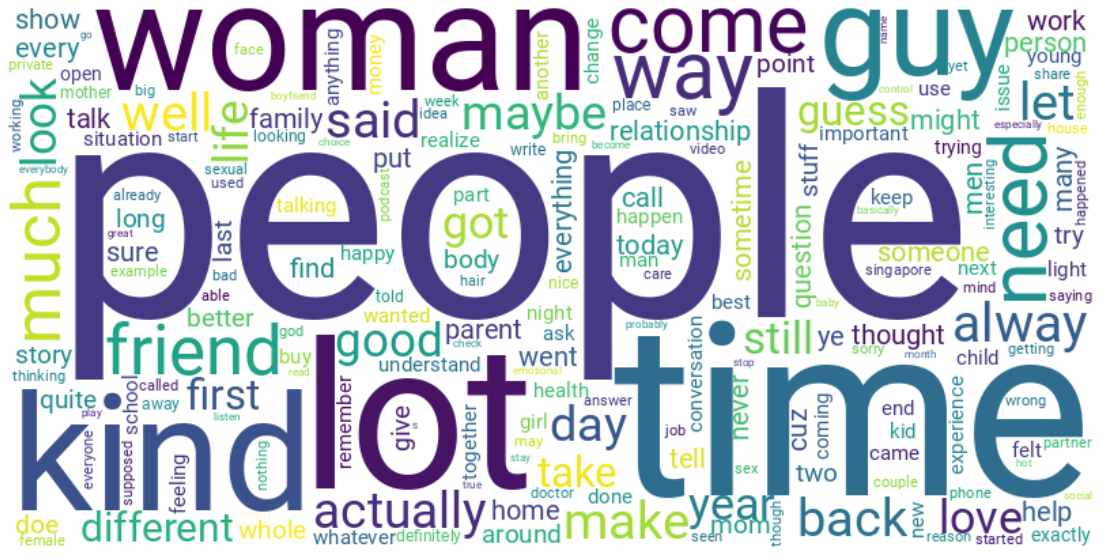

In [26]:
wordcloud_1 = WordCloud(font_path = '/Users/lukasiwei/Desktop/dsi25-workspace/Projects/capstone_project/media/Roboto-Regular.ttf', collocations = False, background_color = 'white', colormap='viridis', width=800, height=400).generate(str(clean_text))

plt.figure(figsize=(20,10))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

The wordcloud however gives a lot less information as many of the words are not meaningful and only serve to join a sentence together. Examples include lot, much, need, always, make.

### Text Extraction with Bag of Words

A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

- A vocabulary of known words
- A measure of the presence of known words

It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document ([source](https://machinelearningmastery.com/gentle-introduction-bag-words-model/)).

In [28]:
# define df
processed_docs = clean_df['lemma_stop_text_column']

In [29]:
# initiate dictionary and obtain list of most frequent words
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 coming
1 nothing
2 declare
3 well
4 beauty
5 cost
6 guess
7 home
8 interesting
9 internet
10 look


The BoW list can be observed to be very different from the CV and TF-IDF ones above.

In [39]:
# filter tokens that appear in <15 documents, > 0.5 documents and keep only the first 100,000 most frequent tokens
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [40]:
# dictionary reporting how many words and how many times those words appear
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(164, 1),
 (215, 2),
 (234, 1),
 (341, 1),
 (378, 1),
 (497, 1),
 (953, 1),
 (978, 1)]

### TF-IDF

In [42]:
# create tf-idf model object and apply transformation to the entire corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.7045249943909955), (1, 0.7096791755986418)]


# LDA Model using BoW

In [43]:
# train lda model with BoW
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [44]:
# print topic words and their corresponding weights
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.029*"people" + 0.012*"also" + 0.012*"could" + 0.011*"make" + 0.010*"lot" + 0.010*"come" + 0.009*"watching" + 0.009*"look" + 0.008*"call" + 0.008*"cuz"
Topic: 1 
Words: 0.017*"lot" + 0.016*"time" + 0.016*"important" + 0.014*"back" + 0.012*"love" + 0.011*"always" + 0.010*"light" + 0.010*"yes" + 0.010*"let" + 0.010*"done"
Topic: 2 
Words: 0.019*"people" + 0.017*"way" + 0.015*"actually" + 0.014*"well" + 0.013*"make" + 0.013*"woman" + 0.013*"good" + 0.013*"time" + 0.010*"game" + 0.010*"need"
Topic: 3 
Words: 0.022*"kind" + 0.018*"always" + 0.015*"woman" + 0.015*"people" + 0.014*"way" + 0.011*"time" + 0.010*"come" + 0.009*"back" + 0.009*"said" + 0.009*"parent"
Topic: 4 
Words: 0.018*"need" + 0.017*"people" + 0.015*"let" + 0.014*"guy" + 0.012*"way" + 0.012*"money" + 0.012*"come" + 0.010*"lot" + 0.010*"kind" + 0.009*"woman"
Topic: 5 
Words: 0.024*"lot" + 0.014*"buy" + 0.014*"look" + 0.013*"love" + 0.013*"day" + 0.012*"much" + 0.011*"question" + 0.010*"different" + 0.010*"aro

## LDA using TF-IDF

In [45]:
# train lda model with TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

# print topic words and their corresponding weights
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.007*"tell" + 0.007*"people" + 0.006*"year" + 0.006*"need" + 0.006*"time" + 0.006*"mom" + 0.006*"friend" + 0.006*"woman" + 0.005*"many" + 0.005*"phone"
Topic: 1 Word: 0.010*"let" + 0.008*"never" + 0.007*"next" + 0.007*"time" + 0.006*"friend" + 0.006*"people" + 0.006*"around" + 0.006*"back" + 0.006*"woman" + 0.006*"actually"
Topic: 2 Word: 0.007*"much" + 0.006*"well" + 0.006*"private" + 0.006*"guess" + 0.006*"find" + 0.006*"life" + 0.006*"maybe" + 0.006*"time" + 0.006*"also" + 0.005*"need"
Topic: 3 Word: 0.008*"good" + 0.007*"give" + 0.007*"life" + 0.006*"self" + 0.006*"time" + 0.005*"way" + 0.005*"people" + 0.005*"question" + 0.005*"kind" + 0.005*"answer"
Topic: 4 Word: 0.008*"angry" + 0.007*"first" + 0.006*"yes" + 0.006*"year" + 0.006*"time" + 0.005*"two" + 0.005*"guess" + 0.005*"woman" + 0.005*"way" + 0.005*"went"
Topic: 5 Word: 0.008*"back" + 0.007*"money" + 0.007*"people" + 0.006*"google" + 0.006*"way" + 0.005*"love" + 0.005*"need" + 0.005*"went" + 0.005*"said" + 0.

# Performance evaluation

The LDA model gave outputs that make interpreting the topics very difficult and that do not seem to have much similarities to the lists obtained using vector frequencies. The outputs seem to suggest that a different treatment is required for obtaining the right word vectors before the weights are applied so that there would be less sentence connectors in the final output.

I observe that the difference between text and speech transcripts can be significant because speech is spontaneous and hence would contain more filler words. In this case, these filler words are still affecting the quality of the analysis output even after I removed a long list of additional stopwords from the corpus.